In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from ReadOut import read_bin_file

from datetime import timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter


print(os.getcwd())

c:\Users\yslug\Desktop\SpaceSystems\LunarLeaper\IMUs\VN100


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


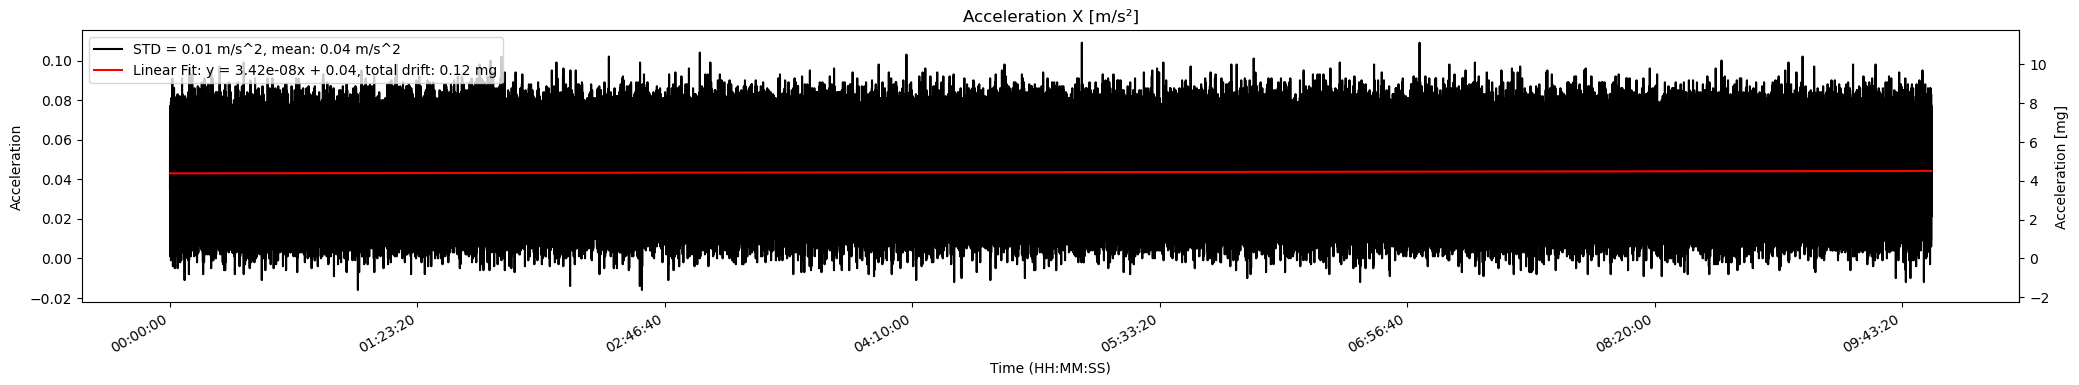

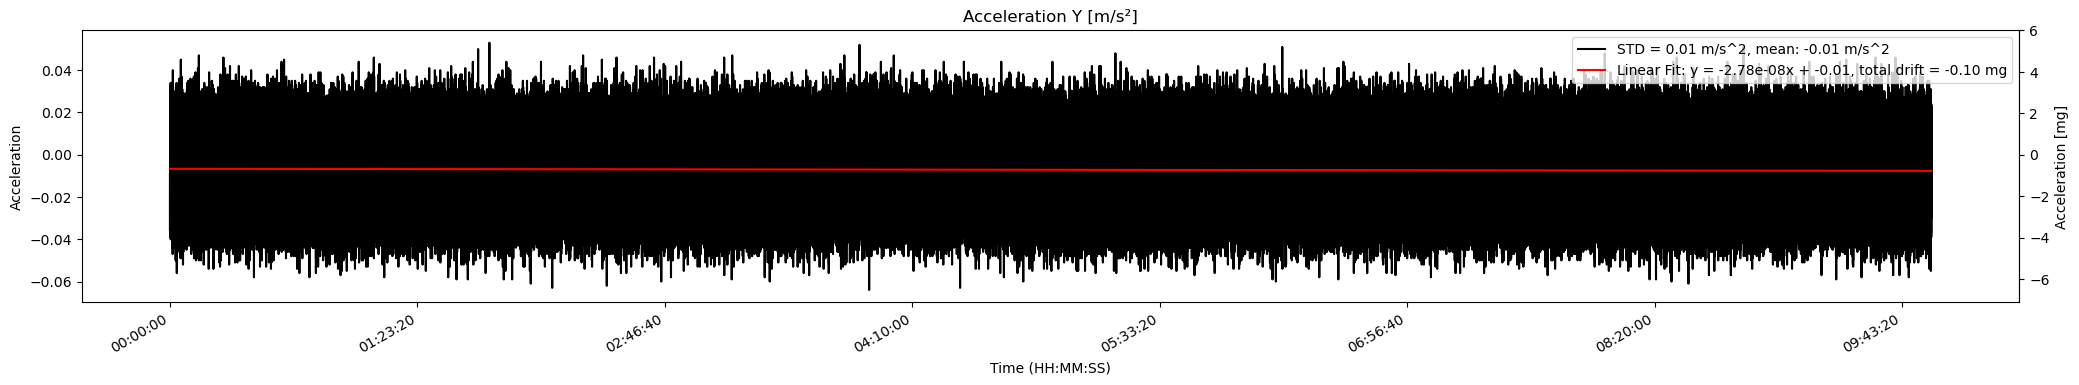

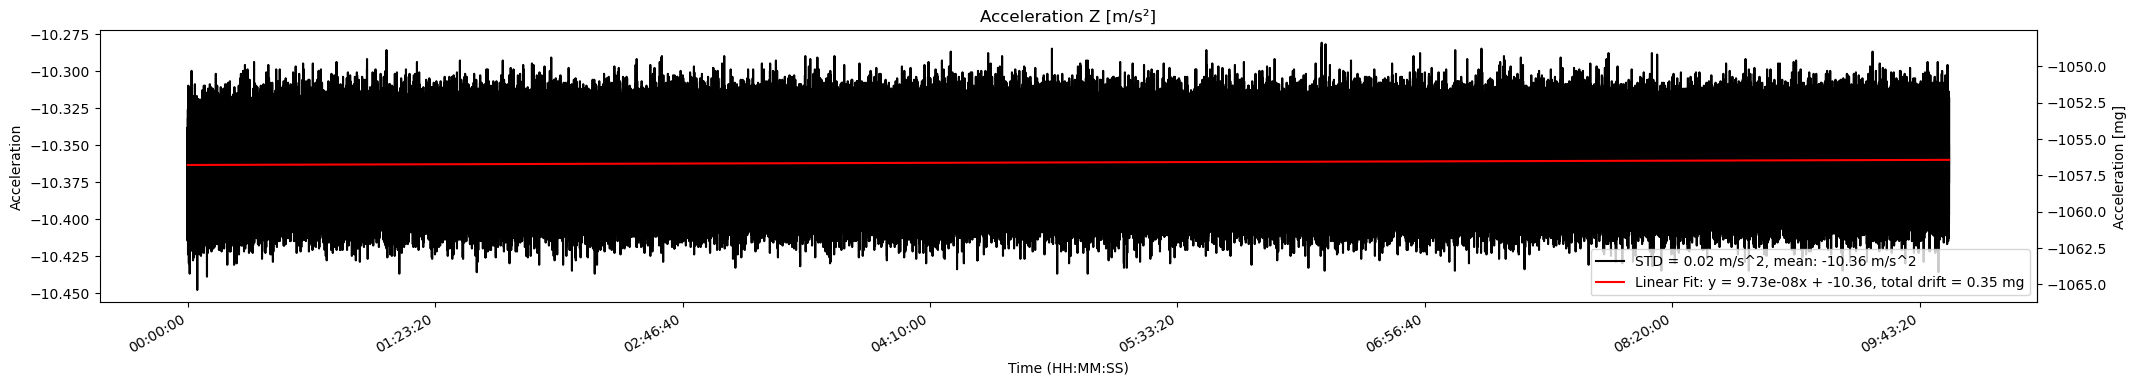

In [2]:

test1 = read_bin_file("Data/Overnight_Test_2405_2213.bin")
time = np.arange(len(test1['accelX'])) * 1 / 40  # in seconds


def seconds_to_hms(x, pos):
    hours = int(x // 3600)
    minutes = int((x % 3600) // 60)
    seconds = int(x % 60)
    return f'{hours:02}:{minutes:02}:{seconds:02}'

def ms2_to_mg(ms2):
    return ms2 / 9.80665 * 1000 

def mg_to_ms2(mg):
    return mg * 9.80665 / 1000  


hms_formatter = FuncFormatter(seconds_to_hms)


# Accel X
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(time, test1['accelX'], "k", label=f'STD = {test1["accelX"].std():.2f} m/s^2, mean: {test1["accelX"].mean():.2f} m/s^2', markersize=1)
a0, a1 = np.polyfit(time, test1['accelX'], 1)
linx =  a0*time + a1
ax.plot(time,linx, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift: {ms2_to_mg(linx[-1] - linx[0]):.2f} mg')

ax.xaxis.set_major_formatter(hms_formatter)
fig.autofmt_xdate()
ax.set_title("Acceleration X [m/s²]")
ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Acceleration")
secax = ax.secondary_yaxis('right', functions=(ms2_to_mg, mg_to_ms2))
secax.set_ylabel('Acceleration [mg]')
ax.legend()

# Accel Y
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(time, test1['accelY'], "k", label=f'STD = {test1["accelY"].std():.2f} m/s^2, mean: {test1["accelY"].mean():.2f} m/s^2', markersize=1)

a0, a1 = np.polyfit(time, test1['accelY'], 1)
liny = a0*time + a1
ax.plot(time,liny, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift = {ms2_to_mg(liny[-1] - liny[0]):.2f} mg')
ax.xaxis.set_major_formatter(hms_formatter)
fig.autofmt_xdate()
ax.set_title("Acceleration Y [m/s²]")
ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Acceleration")
secax = ax.secondary_yaxis('right', functions=(ms2_to_mg, mg_to_ms2))
secax.set_ylabel('Acceleration [mg]')
ax.legend()

# Accel Z
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(time, test1['accelZ'], "k", label=f'STD = {test1["accelZ"].std():.2f} m/s^2, mean: {test1["accelZ"].mean():.2f} m/s^2', markersize=1)

a0, a1 = np.polyfit(time, test1['accelZ'], 1)
linz =  a0*time + a1
ax.plot(time, linz, 'r', label=f'Linear Fit: y = {a0:.2e}x + {a1:.2f}, total drift = {ms2_to_mg(linz[-1] - linz[0]):.2f} mg')
ax.xaxis.set_major_formatter(hms_formatter)
fig.autofmt_xdate()
ax.set_title("Acceleration Z [m/s²]")
ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Acceleration")
secax = ax.secondary_yaxis('right', functions=(ms2_to_mg, mg_to_ms2))
secax.set_ylabel('Acceleration [mg]')
ax.legend()

plt.show()


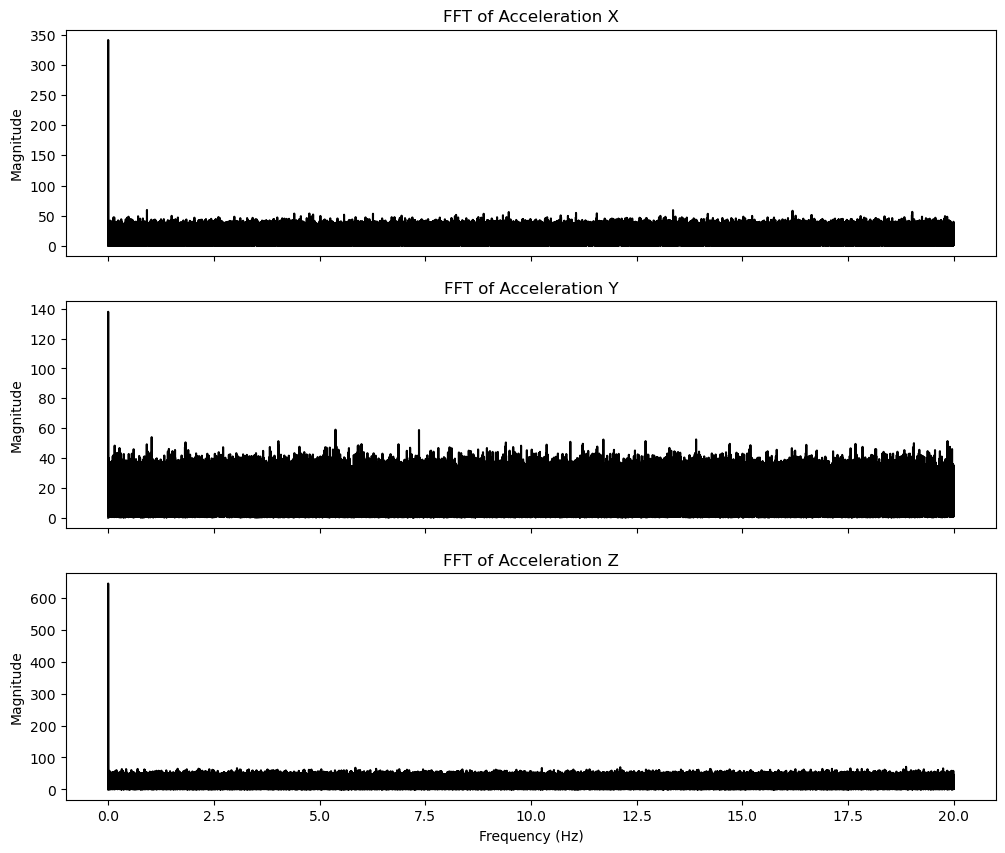

In [3]:
fs = 40  


def compute_fft(signal, fs):

    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/fs)

    magnitude = np.abs(fft_result[:len(signal)//2])
    frequencies = frequencies[:len(signal)//2]

    return frequencies, magnitude

freq_x, mag_x = compute_fft(test1['accelX']-linx, fs)
freq_y, mag_y = compute_fft(test1['accelY']-liny, fs)
freq_z, mag_z = compute_fft(test1['accelZ']-linz, fs)


fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axs[0].plot(freq_x, mag_x, "k", markersize=1)
axs[0].set_title("FFT of Acceleration X")
axs[0].set_ylabel("Magnitude")

axs[1].plot(freq_y, mag_y, "k", markersize=1)
axs[1].set_title("FFT of Acceleration Y")
axs[1].set_ylabel("Magnitude")

axs[2].plot(freq_z, mag_z, "k", markersize=1)
axs[2].set_title("FFT of Acceleration Z")
axs[2].set_ylabel("Magnitude")
axs[2].set_xlabel("Frequency (Hz)")

plt.show()


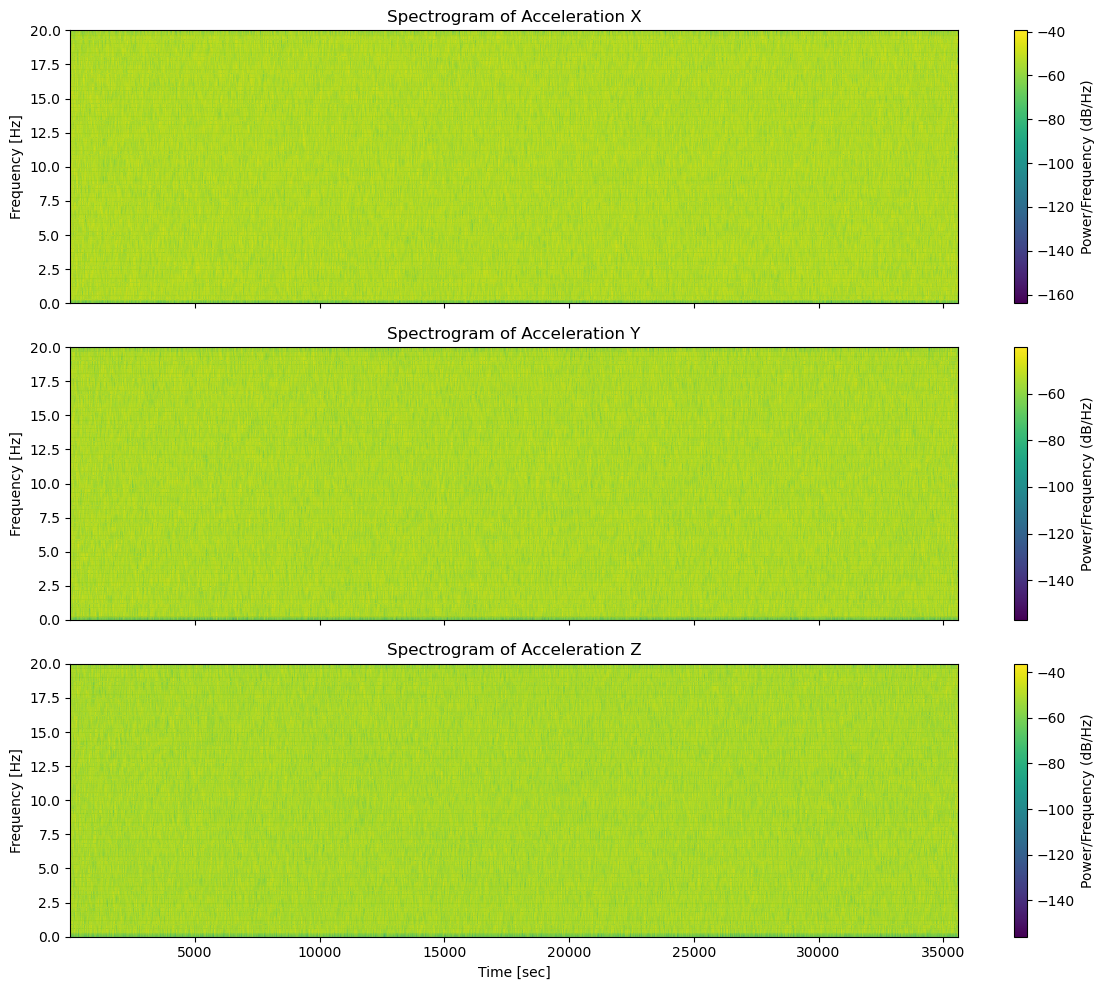

In [4]:
from scipy.signal import spectrogram

fs = 40  # Sampling frequency

def compute_spectrogram(signal, fs, nperseg=128, noverlap=64):
    f, t, Sxx = spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)
    return f, t, Sxx

# Remove mean before computing spectrogram (detrend)
f_x, t_x, Sxx_x = compute_spectrogram(test1['accelX'] - np.mean(test1['accelX']), fs)
f_y, t_y, Sxx_y = compute_spectrogram(test1['accelY'] - np.mean(test1['accelY']), fs)
f_z, t_z, Sxx_z = compute_spectrogram(test1['accelZ'] - np.mean(test1['accelZ']), fs)

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

im0 = axs[0].pcolormesh(t_x, f_x, 10 * np.log10(Sxx_x), shading='gouraud')
axs[0].set_title('Spectrogram of Acceleration X')
axs[0].set_ylabel('Frequency [Hz]')
fig.colorbar(im0, ax=axs[0], label='Power/Frequency (dB/Hz)')

im1 = axs[1].pcolormesh(t_y, f_y, 10 * np.log10(Sxx_y), shading='gouraud')
axs[1].set_title('Spectrogram of Acceleration Y')
axs[1].set_ylabel('Frequency [Hz]')
fig.colorbar(im1, ax=axs[1], label='Power/Frequency (dB/Hz)')

im2 = axs[2].pcolormesh(t_z, f_z, 10 * np.log10(Sxx_z), shading='gouraud')
axs[2].set_title('Spectrogram of Acceleration Z')
axs[2].set_ylabel('Frequency [Hz]')
axs[2].set_xlabel('Time [sec]')
fig.colorbar(im2, ax=axs[2], label='Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()